In [1]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [2]:
import deepchem as dc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
import tensorflow as tf

from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.models.graph_models import GraphConvModel
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from deepchem.metrics import to_one_hot
from deepchem.utils.data_utils import load_from_disk

In [3]:
sns.set_style('whitegrid')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "drive/MyDrive/Colab Notebooks/data/"

In [ ]:
!ls drive/MyDrive/"Colab Notebooks"/data/

preprocessed_data.csv  test.csv		 train.csv
sample_submission.csv  test_fps_mol.csv  train_fps_mol.csv


In [ ]:
df = pd.read_csv(path + "train_fps_mol.csv")
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps,mol
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7e0971daa420>
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7e0971daa880>
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7e0971da9fc0>
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,[0. 0. 1. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7e0971da9f50>
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7e0971dabed0>


In [ ]:
df.columns

Index(['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'fps', 'mol'],
      dtype='object')

In [ ]:
mlm_column = ['SMILES', 'MLM']
hlm_column = ['SMILES', 'HLM']

In [ ]:
mlm_df = df[mlm_column]
hlm_df = df[hlm_column]

In [ ]:
mlm_df.to_csv(path + "mlm_df.csv", index=False, encoding="utf-8-sig")
hlm_df.to_csv(path + "hlm_df.csv", index=False, encoding="utf-8-sig")

In [6]:
featurizer = dc.feat.ConvMolFeaturizer()
splitter = dc.splits.RandomSplitter()

# MLM

In [7]:
loader_m = dc.data.CSVLoader(tasks=["MLM"], feature_field="SMILES",featurizer=featurizer)

In [8]:
dataset_m = loader_m.create_dataset(path + "mlm_df.csv")
dataset_m

<DiskDataset X.shape: (3487,), y.shape: (3487, 1), w.shape: (3487, 1), task_names: ['MLM']>

In [9]:
train_dataset_m, valid_dataset_m, test_dataset_m = splitter.train_valid_test_split(dataset_m)

In [10]:
model_m = GraphConvModel(n_tasks=1, mode='regression', batch_size=50, dropout=0.3, batch_normalize=True,
                       model_dir="./mlm") # , random_seed=0

In [11]:
from tqdm import tqdm

In [15]:
losses_m = []

for epoch in tqdm(range(1500)):
    loss = model_m.fit(train_dataset_m, nb_epoch=1)  # 1 epoch씩 학습
    losses_m.append(loss)

100%|██████████| 1500/1500 [43:07<00:00,  1.73s/it]


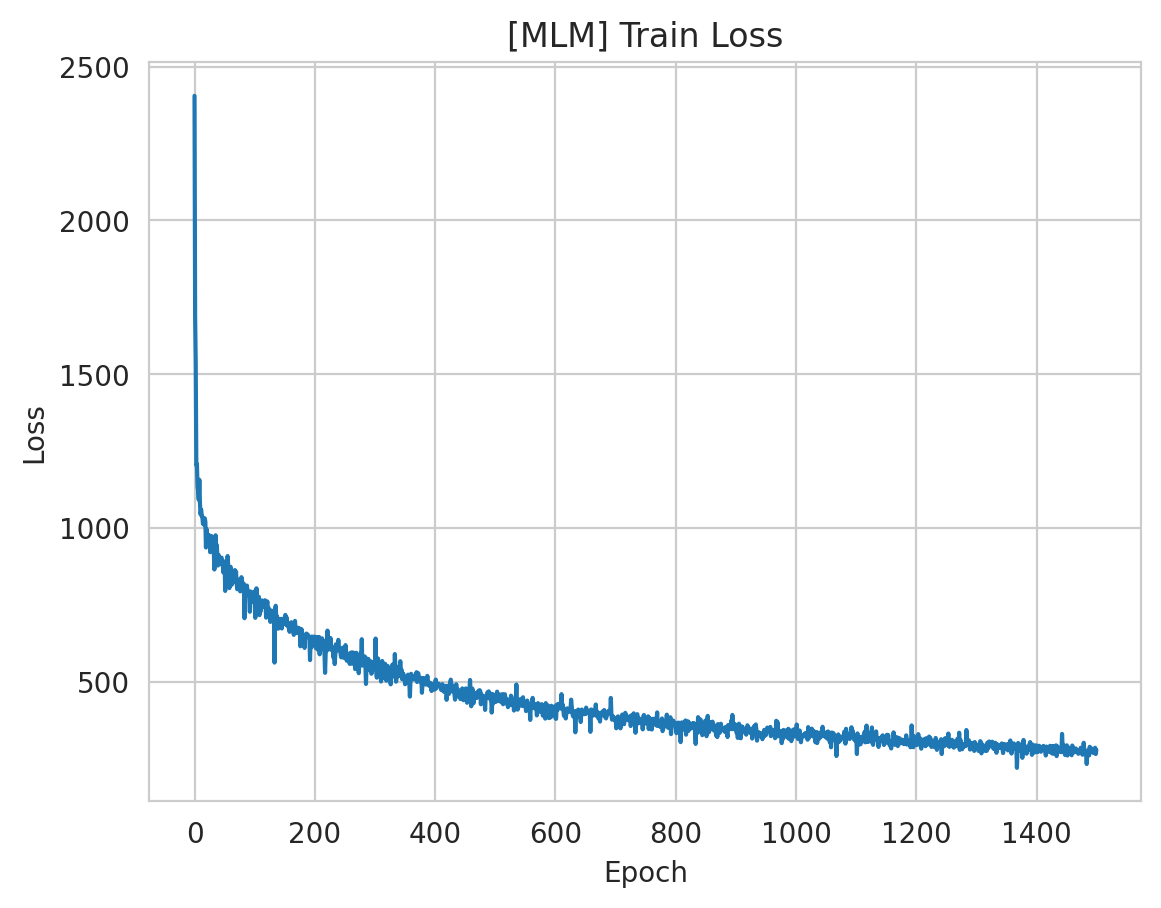

In [16]:
plt.plot(losses_m)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('[MLM] Train Loss')
plt.show()

In [18]:
valid_m_evaluation = model_m.evaluate(valid_dataset_m, [dc.metrics.Metric(dc.metrics.mean_squared_error, mode="regression")])

In [19]:
valid_m_evaluation

{'mean_squared_error': 1382.9732412345534}

In [24]:
print("RMSE :", np.sqrt(valid_m_evaluation['mean_squared_error']))

RMSE : 37.18834819179999


In [ ]:
def show_reg_result(y_test, y_pred, N=50):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    R2 = r2_score(y_test, y_pred)
    max_err = np.abs(y_test - y_pred).max()

    print('R2:', round(R2,4))
    print('MAE:', round(mae, 4))
    print('RMSE:', round(rmse,4))
    print('Max error:', round(max_err, 4))

    # 일부 실제값과 예측값 샘플을 plot으로 비교하여 그려본다 (N 개)

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel('Mouse Liver Microsome')
      plt.show()

R2: 0.1067
MAE: 26.6087
RMSE: 34.3392
Max error: 103.131


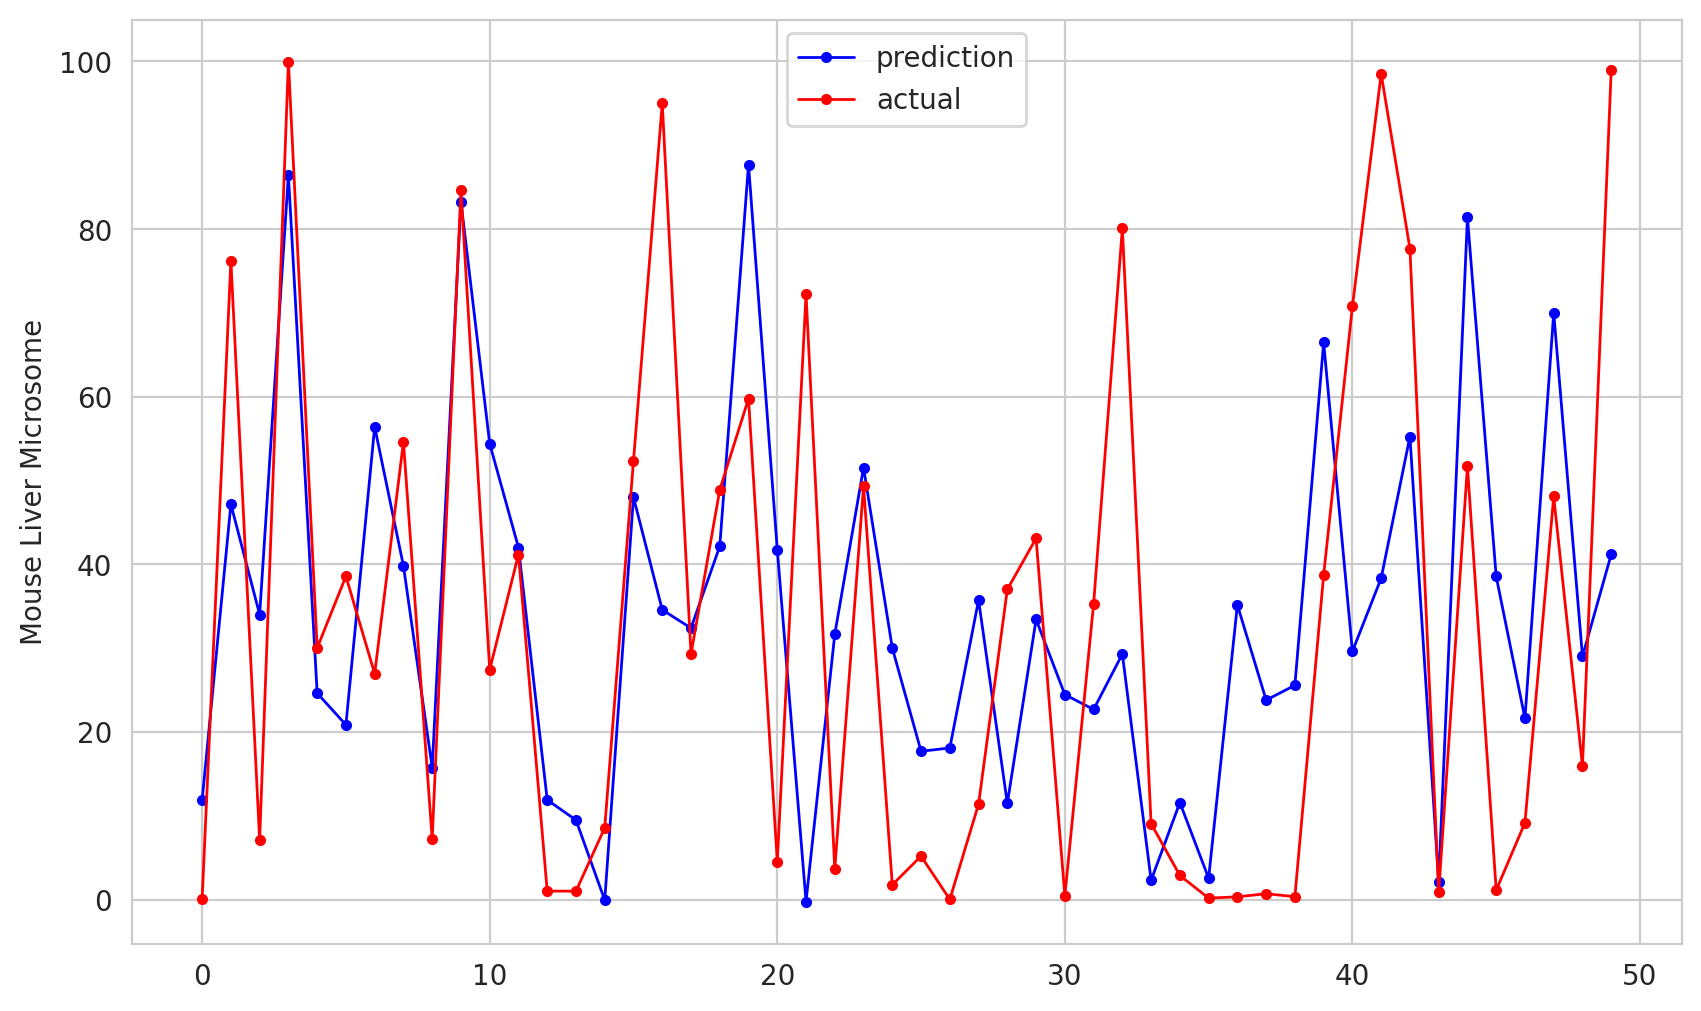

In [ ]:
y_pred = model_m.predict(test_dataset_m)
show_reg_result(test_dataset_m.y, y_pred)

# HLM

In [25]:
loader_h = dc.data.CSVLoader(tasks=["HLM"], feature_field="SMILES",featurizer=featurizer)
dataset_h = loader_h.create_dataset(path + "hlm_df.csv")
train_dataset_h, valid_dataset_h, test_dataset_h = splitter.train_valid_test_split(dataset_h)

In [26]:
model_h = GraphConvModel(n_tasks=1, mode='regression', batch_size=50,
                       model_dir="./hlm") # , random_seed=0

In [27]:
losses_h = []

for epoch in tqdm(range(1500)):
    loss = model_h.fit(train_dataset_h, nb_epoch=1)  # 1 epoch씩 학습
    losses_h.append(loss)

100%|██████████| 1500/1500 [42:45<00:00,  1.71s/it]


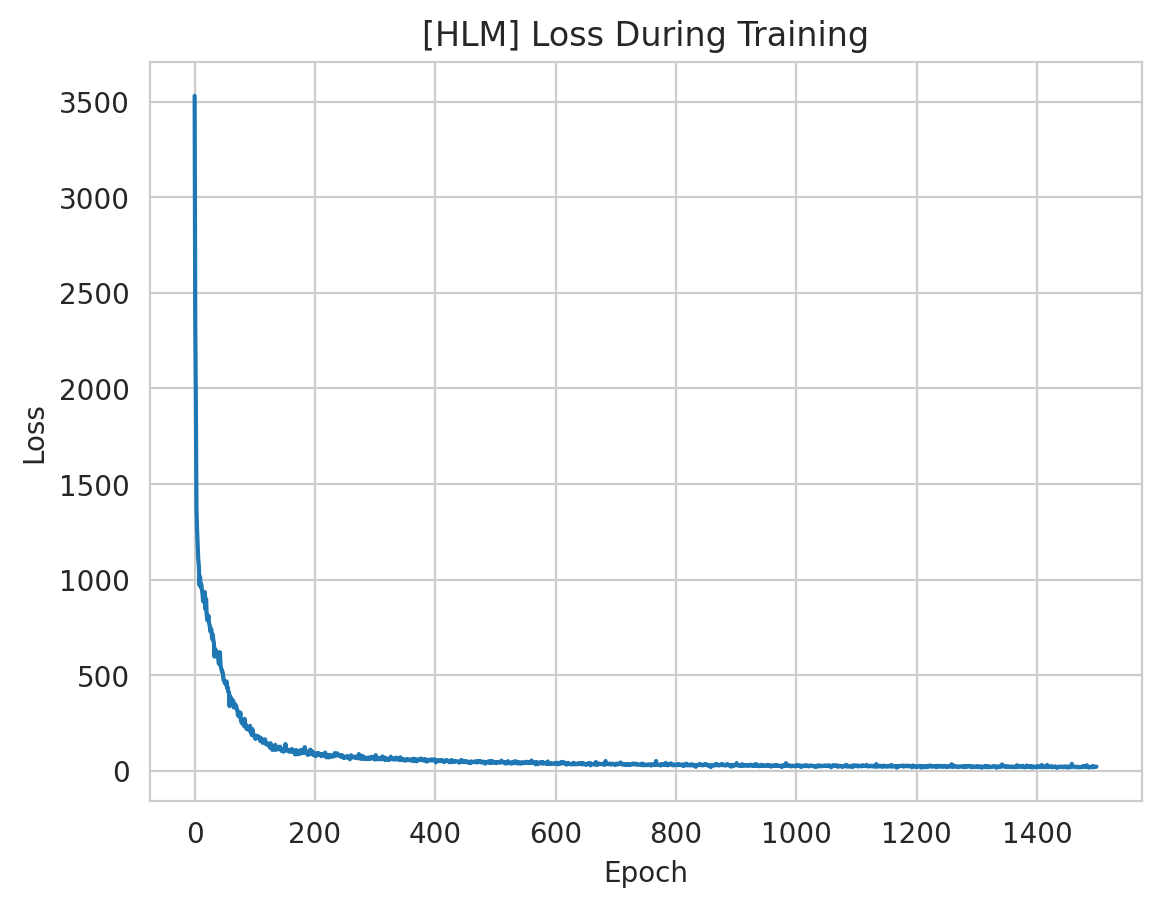

In [28]:
plt.plot(losses_h)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('[HLM] Loss During Training')
plt.show()

In [29]:
valid_h_evaluation = model_h.evaluate(valid_dataset_h, [dc.metrics.Metric(dc.metrics.mean_squared_error, mode="regression")])
valid_h_evaluation

{'mean_squared_error': 1266.698656895149}

In [30]:
print("RMSE :", np.sqrt(valid_h_evaluation['mean_squared_error']))

RMSE : 35.590710261178394


R2: -0.0409
MAE: 28.1725
RMSE: 36.1946
Max error: 100.5467


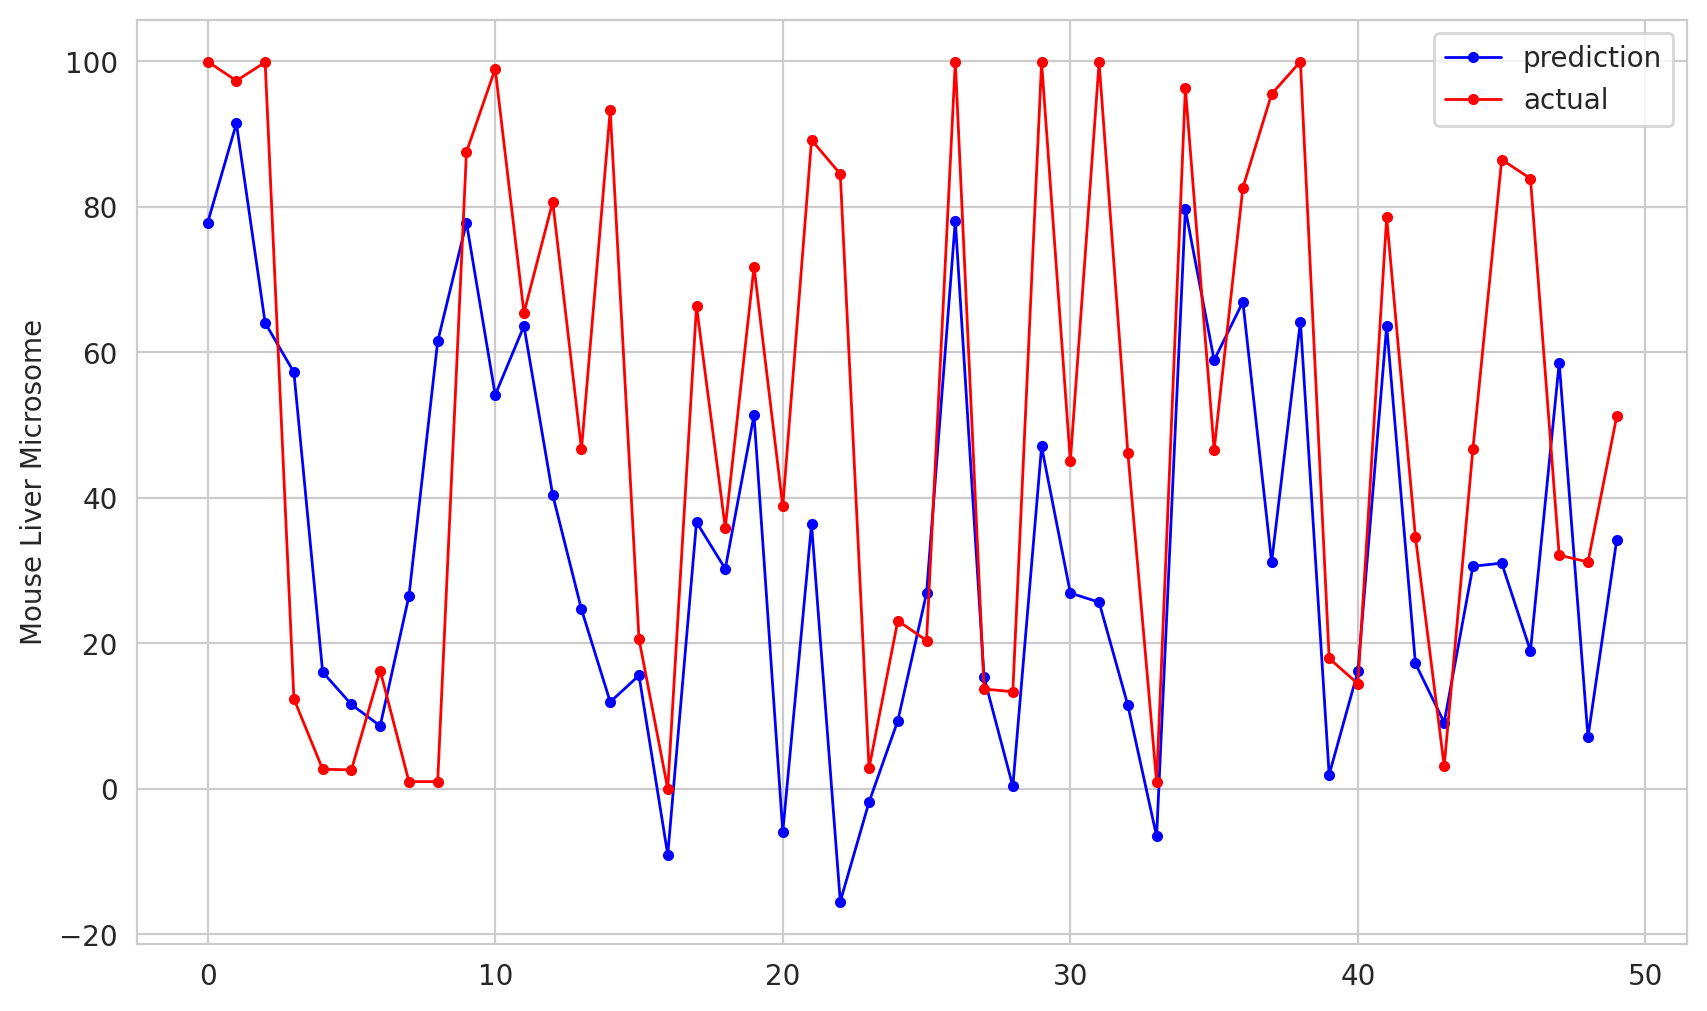

In [ ]:
y_pred = model_h.predict(test_dataset_h)
show_reg_result(test_dataset_h.y, y_pred)

In [ ]:
test_dataset_h

<DiskDataset X.shape: (349,), y.shape: (349, 1), w.shape: (349, 1), ids: ['N#Cc1c(NC(=O)c2n[nH]c(-n3cnnc3)n2)sc2c1CCCC2'
 'O=C(Cn1nc2c(cc1=O)CCCC2)NCC1CCC(C(=O)O)CC1'
 'CC(Sc1nnnn1C(C)C)C(=O)C12CC3CC(CC(C3)C1)C2' ...
 'Cc1ccn(S(=O)(=O)c2cc(C)c(C)cc2Br)n1'
 'c1ccc(-c2ncc(CNc3cccc(-c4nnc[nH]4)c3)s2)nc1'
 'CN(C(=O)CN1C(=O)COc2cc(Cl)c(Cl)cc21)C(CN1CCCC1)c1ccc(-c2ncccn2)cc1'], task_names: ['HLM']>

# Test df로 예측 값 얻기

In [31]:
test_df = pd.read_csv(path + 'test.csv')

In [ ]:
test_df[['SMILES']].to_csv(path + 'test_smile.csv', index=False, encoding="utf-8-sig")

In [32]:
test_features = featurizer.featurize(test_df['SMILES'])

In [ ]:
test_dataset_h

<DiskDataset X.shape: (349,), y.shape: (349, 1), w.shape: (349, 1), ids: ['N#Cc1c(NC(=O)c2n[nH]c(-n3cnnc3)n2)sc2c1CCCC2'
 'O=C(Cn1nc2c(cc1=O)CCCC2)NCC1CCC(C(=O)O)CC1'
 'CC(Sc1nnnn1C(C)C)C(=O)C12CC3CC(CC(C3)C1)C2' ...
 'Cc1ccn(S(=O)(=O)c2cc(C)c(C)cc2Br)n1'
 'c1ccc(-c2ncc(CNc3cccc(-c4nnc[nH]4)c3)s2)nc1'
 'CN(C(=O)CN1C(=O)COc2cc(Cl)c(Cl)cc21)C(CN1CCCC1)c1ccc(-c2ncccn2)cc1'], task_names: ['HLM']>

In [33]:
test_set = dc.data.NumpyDataset(test_features)
test_set

<NumpyDataset X.shape: (483,), y.shape: (483, 1), w.shape: (483, 1), ids: [0 1 2 ... 480 481 482], task_names: [0]>

In [34]:
model_h.restore()
model_m.restore()

In [35]:
pred_mlm = model_m.predict(test_set)
pred_hlm = model_h.predict(test_set)

In [ ]:
test_df.columns

Index(['id', 'SMILES', 'AlogP', 'Molecular_Weight', 'Num_H_Acceptors',
       'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea'],
      dtype='object')

In [36]:
sub_df = pd.read_csv(path + "sample_submission.csv")

In [38]:
sub_df['HLM'] = pred_hlm
sub_df["MLM"] = pred_mlm

In [39]:
sub_df

,id,MLM,HLM
0,TEST_000,16.160250,73.883385
1,TEST_001,90.924744,76.420204
2,TEST_002,82.915939,66.650505
3,TEST_003,31.760981,35.520599
4,TEST_004,42.824139,95.638191
...,...,...,...
478,TEST_478,8.417977,48.174984
479,TEST_479,97.439545,93.336395
480,TEST_480,-0.282715,20.255205
481,TEST_481,53.125229,46.478828


In [42]:
sub_df.to_csv(path + "submission.csv", index=False, encoding="utf-8-sig")

In [41]:
path

'drive/MyDrive/Colab Notebooks/data/'